In [1]:
import os
import time

import numpy as np
from scipy.stats import unitary_group
from opt_einsum import contract
import tensorflow as tf

from src.QDDPM_tf import MultiQubitDiffusionModel, QDDPM, naturalDistance

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc('axes', linewidth=3)

c:\Users\Bingzhi\envs\tensorCircuit_tf\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())
Please first ``pip install -U qiskit`` to enable related functionality in translation module
Please first ``pip install -U cirq`` to enable related functionality in translation module


# functions

In [2]:
def corrNoiseEnsemble(psi0, delta, p, Ndata, seed):
    '''
    generate random states by applying exp(-i\epsilon XX) with probability p
    or exp(-i\epsilon ZZ) with probability 1-p on \psi_0
    \epsilon \in [-\delta, \delta]
    '''
    np.random.seed(seed)
    noise_types = np.random.choice([1, 2], size=Ndata, replace=True, p=[p, 1-p])
    X = np.array([[0, 1.], [1., 0]])
    Z = np.array([[1., 0], [0, -1.]])
    XX = contract('ij,kl->ikjl', X, X).reshape((4, 4))
    ZZ = contract('ij,kl->ikjl', Z, Z).reshape((4, 4))
    angles = np.random.uniform(-delta, delta, Ndata).reshape((Ndata, 1, 1))
    xx_angles = angles[noise_types==1]
    zz_angles = angles[noise_types==2]
    Rxx = np.cos(xx_angles)*np.eye(4) - 1j*np.sin(xx_angles)*XX
    Rzz = np.cos(zz_angles)*np.eye(4) - 1j*np.sin(zz_angles)*ZZ
    Us = np.vstack((Rxx, Rzz))
    states = contract('mij, j->mi', Us, psi0)
    return states

# Diffusion process

## generate samples through diffusion

In [ ]:
# generate noisy ensemble
n = 2
T = 20
Ndata = 5000
delta = np.pi/3.
p = 0.8

diff_hs = np.hstack((np.linspace(0.05, 1., 12), np.linspace(1.2, 4., 8))).astype(np.float32)

psi0 = np.array([np.sqrt(0.1)*np.exp(1j*0.8), np.sqrt(0.55)*np.exp(1j*1.7), 
                    0., np.sqrt(0.35)*np.exp(1j*2.4)])
X = tf.convert_to_tensor(corrNoiseEnsemble(psi0, delta, p, N, seed=15))

Xout = np.zeros((T+1, Ndata, 2**n), dtype=np.complex64)
Xout[0] = X

model_diff = MultiQubitDiffusionModel(n, T, Ndata)
for t in range(1, T+1):
    Xout[t] = model_diff.set_diffusionDataMulti_t(t, X, diff_hs[:t], seed=t)
    print(t)
np.save('data/noise/corrNoiseDiff_n2T_N5000.npy', Xout)

Text(0.5, 0, '$t$')

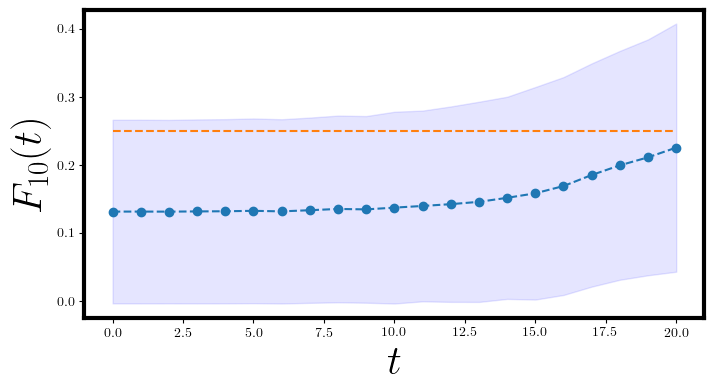

In [3]:
T = 20
N = 5000
X = np.load('data/noise/corrNoiseDiff_n2T%d_N%d.npy'%(T, N))

plt.figure(figsize=(8, 4))
plt.plot(range(T+1), np.mean(np.abs(X[:,:,2])**2, axis=1), 'o--')
plt.fill_between(range(T+1), np.mean(np.abs(X[:,:,2])**2, axis=1) - np.std(np.abs(X[:,:,2])**2, axis=1),
                 np.mean(np.abs(X[:,:,2])**2, axis=1) + np.std(np.abs(X[:,:,2])**2, axis=1), 
                 color='b', alpha=0.1)
plt.plot(range(T+1), np.ones(T+1)*0.25, '--')
plt.ylabel(r'$F_{10}(t)$', fontsize=30)
plt.xlabel(r'$t$', fontsize=30)

# Backward training

In [3]:
def Training_t(model, t, inputs_T, params_tot, Ndata, epochs):
    '''
    training for the backward PQC at step t using whole dataset
    Args:
    model: QDDPM model
    t: diffusion step
    params_tot: collection of PQC parameters for steps > t 
    Ndata: number of samples in training data set
    epochs: number of iterations
    '''
    input_tplus1 = model.prepareInput_t(inputs_T, params_tot, t, Ndata) # prepare input
    states_diff = model.states_diff
    loss_hist = [] # record of training history

    # initialize parameters
    tf.random.set_seed(None)
    params_t = tf.Variable(tf.random.normal([2 * model.n_tot * model.L]))
    # set optimizer and learning rate decay
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

    t0 = time.time()
    for step in range(epochs):
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]
        with tf.GradientTape() as tape:
            output_t = model.backwardOutput_t(input_tplus1, params_t)
            loss = naturalDistance(output_t, true_data)
        grads = tape.gradient(loss, [params_t])
        optimizer.apply_gradients(zip(grads, [params_t]))

        loss_hist.append(tf.stop_gradient(loss)) # record the current loss
        
        if step%100 == 0:
            loss_value = loss_hist[-1]
            print("Step %s, loss: %s, time elapsed: %s seconds"%(step, loss_value, time.time() - t0))
        
    return tf.stop_gradient(params_t), tf.squeeze(tf.stack(loss_hist))

In [ ]:
n, na = 2, 2
T = 20
L = 6
Ndata = 500
epochs = 1001

model_diff = MultiQubitDiffusionModel(n, T, Ndata)
inputs_T = model_diff.HaarSampleGeneration(Ndata, seed=22)

model = QDDPM(n=n, na=na, T=T, L=L)
states_diff = np.load('data/noise/corrNoiseDiff_n%dT%d_N5000.npy'%(n, T))
model.set_diffusionSet(states_diff)


for t in range(T-1, -1, -1):
    params_tot = np.zeros((T, 2*(n+na)*L))
    for tt in range(t+1, 20):
        params_tot[tt] = np.load('data/noise/QDDPMcorrNoiseparams_n2na2T20L6_t%d_mmd.npy'%tt)
    
    params, loss = Training_t(model, t, inputs_T, params_tot, Ndata, epochs)
np.save('data/noise/QDDPMcorrNoiseparams_n2na2T20L6_t%d_mmd.npy'%t, params)
np.save('data/noise/QDDPMcorrNoiselosshist_n2na2T20L6_t%d_mmd.npy'%t, loss)

# Performance

## generate training and testing data

In [2]:
# collect optimized results
n, na = 2, 2
T = 20
L = 6
Ndata = 500

loss_tot = np.zeros((T, 2500))
params_tot = np.zeros((T, 2*(n+na)*L))
for t in range(T):
    loss_each = np.load('data/noise/QDDPMcorrNoiseloss_n2na2T20L6_t%d_mmd.npy'%t)
    loss_tot[t] = loss_each
    params_tot[t] = np.load('data/noise/QDDPMcorrNoiseparams_n2na2T20L6_t%d_mmd.npy'%t)

np.save('data/noise/QDDPMcorrNoiseloss_n2na2T20L6_mmd.npy', loss_tot)
np.save('data/noise/QDDPMcorrNoiseparams_n2na2T20L6_mmd.npy', params_tot)

In [9]:
# generate training and test data from Haar ensemble
n, na = 2, 2
T = 20
L = 6
Ndata = 500

model_diff = MultiQubitDiffusionModel(n, T, Ndata)
inputs_T_tr = model_diff.HaarSampleGeneration(Ndata, seed=22)
inputs_T_te = model_diff.HaarSampleGeneration(Ndata, seed=50)

params_tot = np.load('data/noise/QDDPMcorrNoiseparams_n2na2T20L6_mmd.npy')

model = QDDPM(n=n, na=na, T=T, L=L)
dataset_train = model.backDataGeneration(inputs_T_tr, params_tot, Ndata)[:, :, :2**n]
dataset_test = model.backDataGeneration(inputs_T_te, params_tot, Ndata)[:, :, :2**n]
np.save('data/noise/QDDPMcorrNoisetrainGen_n2na2T20L6_mmd.npy', dataset_train)
np.save('data/noise/QDDPMcorrNoisetestGen_n2na2T20L6_mmd.npy', dataset_test)

## visualize in fidelity

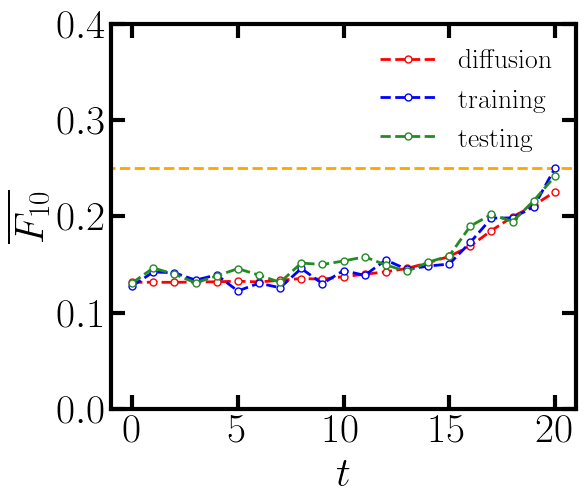

In [10]:
n, na = 2, 2
T = 20
L = 6
Ndata = 500

states_diff = np.load('data/noise/corrNoiseDiff_n2T20_N5000.npy')
gen_data_tr = np.load('data/noise/QDDPMcorrNoisetraingen_n2na2T20L6_mmd.npy')
gen_data_te = np.load('data/noise/QDDPMcorrNoisetestgen_n2na2T20L6_mmd.npy')

f10_diff = np.abs(states_diff[:, :, 2])**2
f10_train = np.abs(gen_data_tr[:, :, 2])**2
f10_test = np.abs(gen_data_te[:, :, 2])**2

fig, ax = plt.subplots(figsize=(6, 5), sharey=True)
ax.plot(range(T+1), np.mean(f10_diff, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='r', 
            zorder=5, label=r'$\rm diffusion$')
ax.plot(range(T+1), np.mean(f10_train, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='b', 
            zorder=5, label=r'$\rm training$')
ax.plot(range(T+1), np.mean(f10_test, axis=1), 'o--', markersize=5, mfc='white', lw=2, 
            c='forestgreen', zorder=5, label=r'$\rm testing$')
ax.set_ylabel(r'$\overline{F_{10}}$', fontsize=30)
ax.set_xlabel(r'$t$', fontsize=30)
ax.legend(fontsize=20, framealpha=0)
ax.hlines(0.25, xmin=-2, xmax=22, ls='--', lw=2, color='orange')
ax.set_xticks(np.arange(0, T+1, 5))
ax.set_yticks(np.arange(5)*0.1)
ax.set_xlim(-1, 21)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

Inference on probability of correlated noise

In [18]:
n, na = 2, 2
T = 20
L = 6
Ndata = 500

states_diff = np.load('data/noise/corrNoiseDiff_n2T20_N5000.npy')
gen_data_tr = np.load('data/noise/QDDPMcorrNoisetraingen_n2na2T20L6_mmd.npy')
gen_data_te = np.load('data/noise/QDDPMcorrNoisetraingen_n2na2T20L6_mmd.npy')

f10_diff = np.abs(states_diff[:, :, 2])**2
f10_train = np.abs(gen_data_tr[:, :, 2])**2
f10_test = np.abs(gen_data_te[:, :, 2])**2

delta = np.pi/3.
p_true = 0.8
sin_avg = (delta-0.5*np.sin(2*delta))/(2*delta)

print("true mean fidelity:%s, training mean fidelity:%s, testing mean fidelity:%s"
      %(np.mean(f10_diff[0]), np.mean(f10_train[0]), np.mean(f10_test[0])))

print("true inferred prob:%s, training inferred prob:%s, testing inferred prob:%s"
      %(np.mean(f10_diff[0])/(sin_avg*0.55), np.mean(f10_train[0])/(sin_avg*0.55), 
        np.mean(f10_test[0])/(sin_avg*0.55)))


true mean fidelity:0.13144667, training mean fidelity:0.12756632, testing mean fidelity:0.12756632
true inferred prob:0.8149790188337253, training inferred prob:0.7909205532944347, testing inferred prob:0.7909205532944347


## visualize in MMD

In [12]:
# calculation
X = tf.convert_to_tensor(np.load('data/noise/corrNoiseDiff_n2T20_N5000.npy'))
X_train = tf.convert_to_tensor(np.load('data/noise/QDDPMcorrNoisetraingen_n2na2T20L6_mmd.npy'))
X_test = tf.convert_to_tensor(np.load('data/noise/QDDPMcorrNoisetestgen_n2na2T20L6_mmd.npy'))

psi0 = np.array([np.sqrt(0.1)*np.exp(1j*0.8), np.sqrt(0.55)*np.exp(1j*1.7), 0., np.sqrt(0.35)*np.exp(1j*2.4)])
X0 = tf.cast(tf.convert_to_tensor(corrNoiseEnsemble(psi0, np.pi/3., 0.8, 5000, seed=18)), tf.complex64)

nd = np.zeros((3, 21))
for t in range(21):
    idx = np.random.choice(5000, 500, replace=False)
    nd[0, t] = naturalDistance(X0[idx], X[t])
    nd[1, t] = naturalDistance(X0[idx], X_train[t])
    nd[2, t] = naturalDistance(X0[idx], X_test[t])
np.save('data/noise/QDDPMcorrNoiseGenloss_n2na2T20L6_mmd.npy', nd)

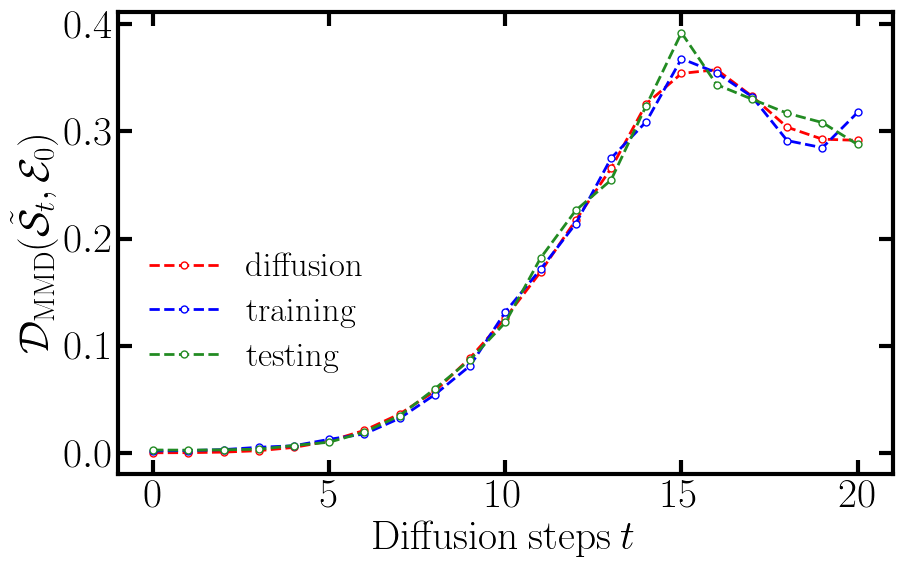

In [15]:
mmds = np.load('data/noise/QDDPMcorrNoiseGenloss_n2na2T20L6_mmd.npy')

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(mmds[0], 'o--', markersize=5, mfc='white', lw=2, c='r', label=r'$\rm diffusion$')
ax.plot(mmds[1], 'o--', markersize=5, mfc='white', lw=2, c='b', label=r'$\rm training$')
ax.plot(mmds[2], 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', label=r'$\rm testing$')
ax.legend(loc='lower left', bbox_to_anchor=(0., 0.15), fontsize=25, framealpha=0, labelspacing=0.4)
ax.set_xlabel(r'${\rm Diffusion\:steps}\:t$', fontsize=30)
ax.set_ylabel(r'$\mathcal{D}_{\rm MMD} (\tilde{\mathcal{S}}_t, \mathcal{E}_0)$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

## plot training history

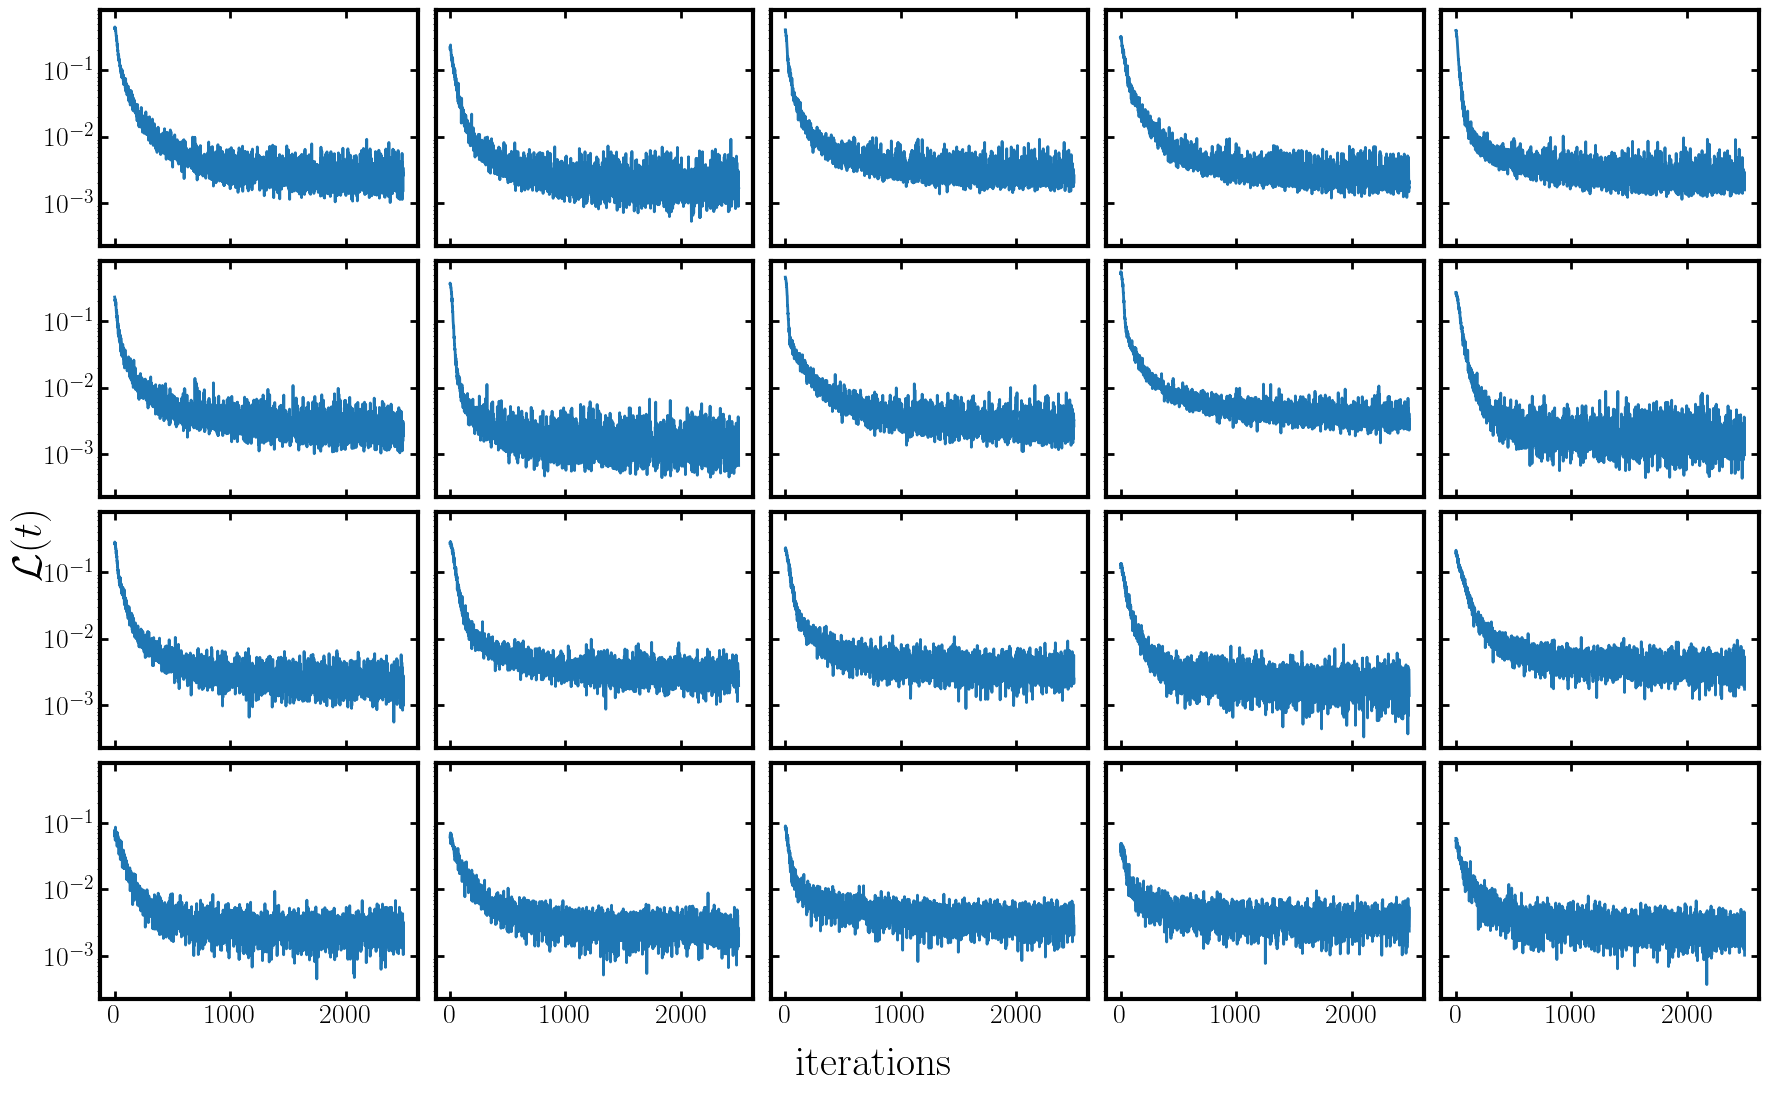

In [16]:
loss = np.load('data/noise/QDDPMcorrNoiseloss_n2na2T20L6_mmd.npy')

fig, axs = plt.subplots(4, 5, figsize=(18, 11), sharex=True, sharey=True)
for i in range(20):
    idx = max(np.where(loss[i] > 0)[0])
    axs[i//5, i%5].plot(loss[i, :idx+1], lw=2)
    axs[i//5, i%5].tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=20)
    #axs[i//5, i%5].text(x=3500, y=0.15, s=r'$t=%d$'%(i+1), fontsize=25)
    axs[i//5, i%5].set_yscale('log')
fig.supxlabel(r'$\rm iterations$', fontsize=30)
fig.supylabel(r'$\mathcal{L}(t)$', fontsize=30)
plt.tight_layout()